In [4]:
import kwant
import kwant
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
from scipy.linalg import eig

In [5]:
lat = kwant.lattice.square(norbs=4)
bulk = kwant.Builder(symmetry=kwant.lattice.TranslationalSymmetry([2,0],[0,2]))

lat_a = kwant.lattice.square(norbs=4)
bulk_a = kwant.Builder(symmetry=kwant.lattice.TranslationalSymmetry([2,0],[0,2]))

In [6]:
def onsite(site):
    return 0 

def hopping_intra(site1, site2, t1):
    return t1

def hopping_inter(site1, site2, t2):
    return t2

bulk[lat(0,0)] = onsite
bulk[lat(0,1)] = onsite
bulk[lat(1,1)] = onsite
bulk[lat(1,0)] = onsite
bulk[lat(0,0),lat(0,1)] = hopping_intra
bulk[lat(0,0),lat(1,0)] = hopping_intra
bulk[lat(1,0),lat(1,1)] = hopping_intra
bulk[lat(0,1),lat(1,1)] = hopping_intra
bulk[lat(0,1),lat(0,2)] = hopping_inter
bulk[lat(1,0),lat(2,0)] = hopping_inter
bulk[lat(1,1),lat(1,2)] = hopping_inter
bulk[lat(1,1),lat(2,1)] = hopping_inter

In [7]:
def onsite_a(site):
    return 0 

def hopping_intra_a(site1, site2, v1):
    return 1j*v1

def hopping_inter_a(site1, site2, v1):
    return 0



bulk_a[lat_a(0,0)] = onsite_a
bulk_a[lat_a(0,1)] = onsite_a
bulk_a[lat_a(1,1)] = onsite_a
bulk_a[lat_a(1,0)] = onsite_a
bulk_a[lat_a(0,0),lat_a(0,1)] = hopping_intra_a
bulk_a[lat_a(0,0),lat_a(1,0)] = hopping_intra_a
bulk_a[lat_a(1,0),lat_a(1,1)] = hopping_intra_a
bulk_a[lat_a(0,1),lat_a(1,1)] = hopping_intra_a
bulk_a[lat_a(0,1),lat_a(0,2)] = hopping_inter_a
bulk_a[lat_a(1,0),lat_a(2,0)] = hopping_inter_a
bulk_a[lat_a(1,1),lat_a(1,2)] = hopping_inter_a
bulk_a[lat_a(1,1),lat_a(2,1)] = hopping_inter_a

In [8]:
finite_h = kwant.Builder()
finite_a = kwant.Builder()

In [9]:
L = 10

def shape(site):
    x, y = abs(site.pos)
    return x < L and y < L 


finite_h.fill(bulk, shape, start=[0,0]);
finite_a.fill(bulk_a, shape, start=[0,0]);

finite_h = finite_h.finalized()
finite_a = finite_a.finalized()


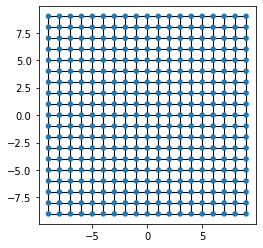

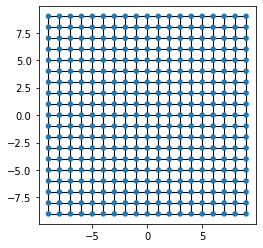

In [10]:
kwant.plot(finite_a)

In [11]:
params_h1 = dict(t1=1, t2=1)
ham_h1 = finite_h.hamiltonian_submatrix(params = params_h1)
params_a1 = dict(v1=0.1)
ham_a1 = finite_a.hamiltonian_submatrix(params = params_a1)

hamiltonian1 = ham_h1 + 1j*ham_a1  

In [12]:
def eig_biort(h):
    eigvals, eigvecL, eigvecR = eig(h, left=True, right=True)

    norm = eigvecL.conj().T @ eigvecR
    eigvecR = eigvecR @ np.linalg.inv(norm)
    assert np.allclose(eigvecL.conj().T @ eigvecR, np.eye(h.shape[0]), atol=1e-5), (np.round(eigvecL.conj().T @ eigvecR, 2), np.round(eigvals))
    assert np.allclose(h @ eigvecR, eigvals * eigvecR, atol=1e-5)
    assert np.allclose(h.T.conj() @ eigvecL, eigvals.conj() * eigvecL, atol=1e-5)
    return eigvals, eigvecL, eigvecR

In [13]:
t1 = 1
d = 0
eig(np.array([[0, t1+d, 0, t1-d],[t1-d, 0, t1+d, 0],[0, t1-d, 0, t1+d],[t1+d, 0, t1-d, 0]]))

(array([ 2.+0.j, -2.+0.j,  0.+0.j,  0.+0.j]),
 array([[-0.5       , -0.5       ,  0.        ,  0.        ],
        [-0.5       ,  0.5       , -0.70710678,  0.70710678],
        [-0.5       , -0.5       ,  0.        ,  0.        ],
        [-0.5       ,  0.5       ,  0.70710678, -0.70710678]]))

In [61]:
def wils(t1, t2, d, ky, Nk=100, EF=0, flux=1):
    
    P = []
    
    gap = np.inf
    
    for kx in np.linspace(-np.pi,np.pi, Nk): 
        
        h0 = np.array([[0, t1+d, 0, t1-d],[t1-d, 0, flux * (t1+d), 0],[0, flux * (t1-d), 0, t1+d],[t1+d, 0, t1-d, 0]])
    
        h1x = np.exp(1j*kx)*np.array([[0,0,0,0],[t2,0,0,0],[0,0,0,t2],[0,0,0,0]])
    
        h2x = np.exp(-1j*kx)*np.array([[0,t2,0,0],[0,0,0,0],[0,0,0,0],[0,0,t2,0]])
        
        h1y = np.exp(1j*ky)*np.array([[0,0,0,t2],[0,0,flux * t2,0],[0,0,0,0],[0,0,0,0]])
    
        h2y = np.exp(-1j*ky)*np.array([[0,0,0,0],[0,0,0,0],[0,flux * t2,0,0],[t2,0,0,0]])
        
        h = h0 + h1x + h2x + h1y + h2y 
        
        evals, evecsR = eig(h) 
        temp = (evecsR) @ np.diag(evals.real < EF) @ evecsR.conj().T  
        
        P.append(temp)
        
        #gap = min(gap,min(abs(evals.real)))
    #plt.scatter(t1, gap, c='b')   #multiply list*integer-> repeat list integer times 
        
    # This is a simpler way to take the product
    w = np.eye(4)
    for p in P:
        assert np.allclose(p@p,p)
        w = p @ w
    #print(gap, eig(w))
    
    kx = -np.pi 
    
    h0 = np.array([[0, t1+d, 0, t1-d],[t1-d, 0, flux * (t1+d), 0],[0, flux * (t1-d), 0, t1+d],[t1+d, 0, t1-d, 0]])
    h1x = np.exp(1j*kx)*np.array([[0,0,0,0],[t2,0,0,0],[0,0,0,t2],[0,0,0,0]])
    h2x = np.exp(-1j*kx)*np.array([[0,t2,0,0],[0,0,0,0],[0,0,0,0],[0,0,t2,0]])   
    h1y = np.exp(1j*ky)*np.array([[0,0,0,t2],[0,0,flux * t2,0],[0,0,0,0],[0,0,0,0]])
    h2y = np.exp(-1j*ky)*np.array([[0,0,0,0],[0,0,0,0],[0,flux * t2,0,0],[t2,0,0,0]])
    
    h = h0 + h1x + h2x + h1y + h2y 
         
    evals_k, evecsR_k = eig(h)
    ind = np.where(evals_k.real < EF)[0] #
    w0 = evecsR_k[:, ind].conj().T @ w @ evecsR_k[:, ind]

    #assert np.allclose(w0 @ w0.T.conj(), np.eye(2))
    w0 = np.linalg.qr(w0.T)[0].T
    #assert np.allclose(w0 @ w0.T.conj(), np.eye(2))

    return w0


In [63]:
w0 = wils(1,0,0,0, 1000, flux=-1, EF=0)

eigvals, eigvecR, eigvecL = eig_biort(w0)

print(np.angle(eigvals) / (2*np.pi))

AssertionError: 

In [56]:
def nest_wils(t1, t2, d, Nk1, Nk2, EF=0,WEF=0, flux=-1):
    
    J = []
    K = []
    for ky in np.linspace(-np.pi,np.pi, Nk2): 
        
        w0 = wils(t1, t2, d, ky, Nk=Nk1, EF=EF, flux=flux)
        
        #evals_w, evecsL_w, evecsR_w = eig_biort(w0) 
        #temp = (evecsR_w) @ np.diag(np.angle(evals_w) < WEF) @ evecsL_w.conj().T 
        evals_w, evecsL_w = eig(w0)
        temp = (evecsL_w) @ np.diag(np.angle(evals_w) < WEF) @ evecsL_w.conj().T 
        assert np.sum(np.angle(evals_w) < WEF)
        J.append(evals_w)
        K.append(temp)
        #print(temp.shape)
        
    w1 = np.eye(2)
    for k in K:
        assert np.allclose(k @ k, k)
        w1 = k @ w1
        print(max(np.abs(eig(w1)[0])))
        
    evals_k, evecsR_k = eig(K[0])
    ind = np.where(np.angle(evals_k) < WEF)[0] #
    w2 = evecsR_k[:, ind].conj().T @ w1 @ evecsR_k[:, ind]    
    return J, w2


In [64]:
J, w1 = nest_wils(1,0.1,0,Nk1=100, Nk2=200, flux=-1, EF=0)

AssertionError: 

In [45]:
J = np.asarray(J)
print(w1.shape)

(1, 1)


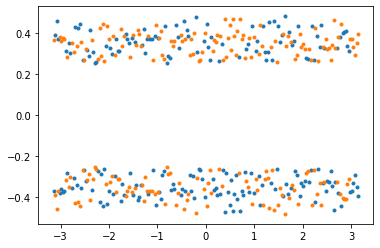

In [46]:
plt.plot(np.linspace(-np.pi,np.pi, 200), (np.angle(J)/(2*np.pi)),'.')

In [ ]:
print(eig(w1))

In [ ]:
np.abs(J[0, 0])